It is very important to keep an eye on emerging hotspots for Covid 19 cases. In this notebook we make a heauristic to capture this. We look at 

$$
\frac{active}{confirmed}
$$

and we take the mean of this over 5 days and ask if this quantity has increased by over 20%. Both the window and the cutoff are configurable below.

We filter by this condition and show in plots how these countries are faring. This method can be adapted to more localized data to look for hotspots (as long as the region under consideration are large enough to give a good signal to noise ratio)

In [184]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import folium

%matplotlib inline

First we get the latest data from the Johns Hopkins GitHub page



In [185]:
confirmed=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

We then remove the latitude and longitude information as well as group by country/region (be sure this is what you want)

In [186]:
def cleaned(df):
    df=df.drop(['Lat','Long'],1).groupby('Country/Region').sum().T
    df.index=pd.DatetimeIndex(df.index,freq='D')
    return df

confirmed,deaths,recovered=map(cleaned,[confirmed,deaths,recovered])


In [187]:
active=confirmed-deaths-recovered

We are going to look at two plots:

1. Absolute number of case of three kinds: active, deaths and recovered
2. The same numbers as above but scaled by the total number of cases

**This second is useful to normalize and compare across countries and across times.**

In [188]:
d=pd.concat({'active':active,'deaths':deaths,'recovered':recovered})
d_scaled=d.div(confirmed,axis=0,level=1)

For example lets look at Italy

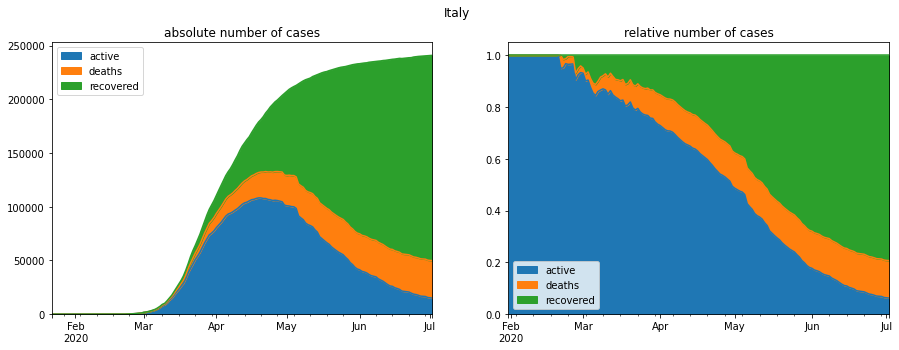

In [190]:
country='Italy'
_,axs=plt.subplots(1,2,figsize=(15,5))
d[country].unstack().T.dropna().plot(kind='area',stacked=True,ax=axs[0])
d_scaled[country].unstack().T.dropna().plot(kind='area',ax=axs[1])
axs[0].set_title('absolute number of cases')
axs[1].set_title('relative number of cases')
plt.suptitle('{}'.format(country))
plt.show()

We see that the fraction of deaths kept increasing with time throughout but we also see that the fraction of active keeps decreasing throughout (almost) as well showing there was no second wave.

Compare with Singapore

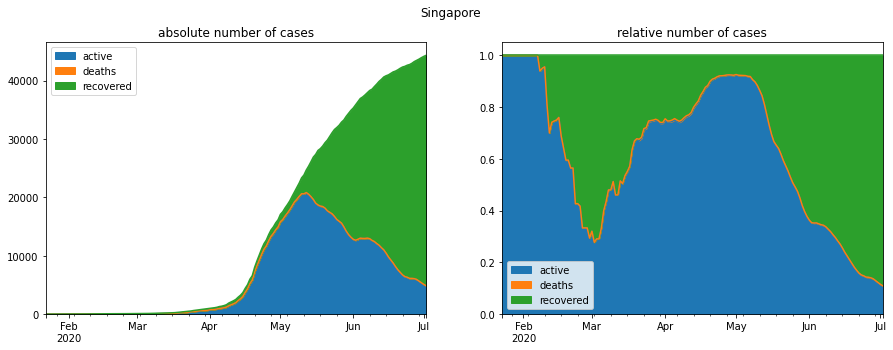

In [191]:
country='Singapore'
_,axs=plt.subplots(1,2,figsize=(15,5))
d[country].unstack().T.dropna().plot(kind='area',stacked=True,ax=axs[0])
d_scaled[country].unstack().T.dropna().plot(kind='area',ax=axs[1])
axs[0].set_title('absolute number of cases')
axs[1].set_title('relative number of cases')
plt.suptitle('{}'.format(country))
plt.show()

This shows its famous second wave in May. This also shows the usefulness of the normalized plot as youo would not have been able to see this in the plot on the left

So one way of checking for hotspots is to look for an _uptick of the fraction of active cases_. We set `cutoff` at 30% increase but this might be too conservative and for earlier signaling we may want to set it lower. We also set the cutoff for active case fraction as 5% otherwise we get false positives for countries where the active cases are so low that a slight uptick makes the percentage increase enormous.

In [205]:
cutoff=1.2
window_size='5d'
active_fraction_cutoff=.05

In [206]:
cond1=d_scaled.loc['active'].resample(window_size).mean().apply(np.log).diff().apply(np.exp).iloc[-1]>cutoff
cond2=d_scaled.loc['active'].iloc[-1]>.02
cond=pd.concat([cond1,cond2],1).all(1)

In [207]:
hotspots=d_scaled.columns[cond]

In [208]:
sorted_hotspot_values=d_scaled.loc['active'].resample(window_size).mean().apply(np.log).diff().apply(np.exp).iloc[-1].loc[hotspots].sort_values(ascending=False)
hotspots=sorted_hotspot_values.index
sorted_hotspot_values

Country/Region
Seychelles     2.009762
Luxembourg     1.873861
Croatia        1.508537
Kazakhstan     1.493406
Montenegro     1.489354
Slovenia       1.471981
Belize         1.463465
Serbia         1.407948
Monaco         1.366081
Australia      1.290475
Switzerland    1.278755
Japan          1.254670
Austria        1.253969
Israel         1.207597
Nicaragua      1.202821
Name: 2020-06-30 00:00:00, dtype: float64

We plot the results below but care must be taken to remember that we have filtered on active case fraction to be above 5% only. If you want a less conservative estimate and want to be more risk averse you should reduce that number.

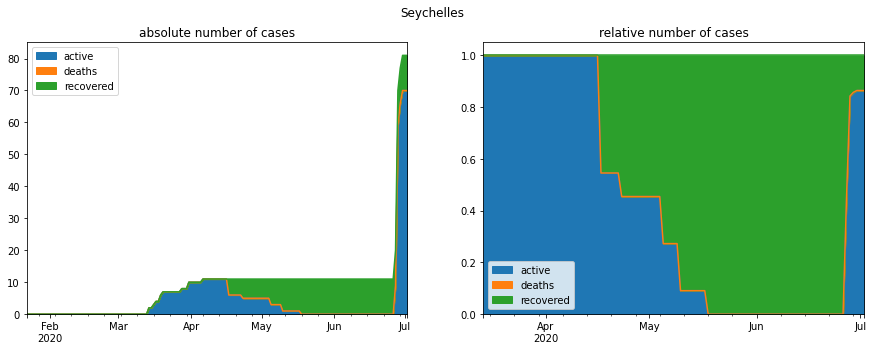

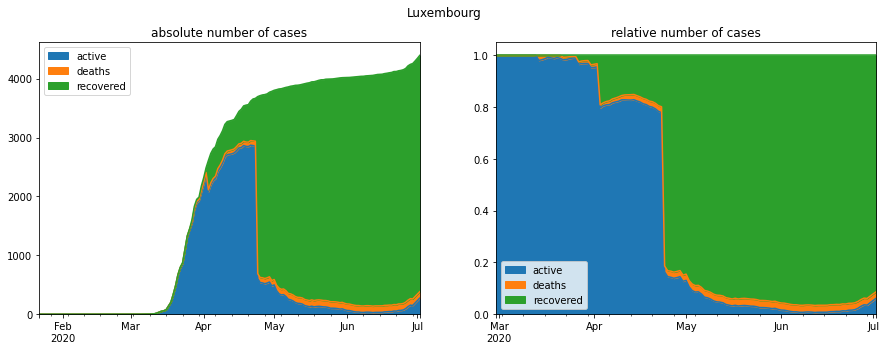

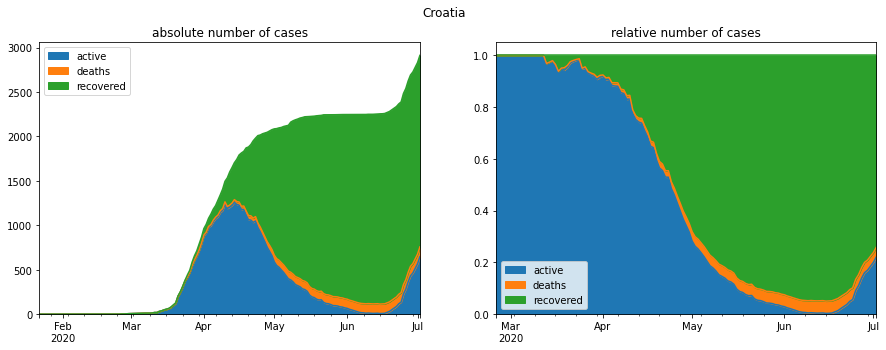

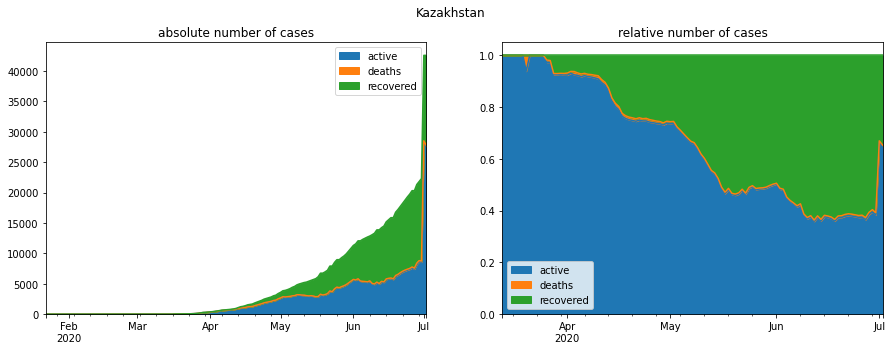

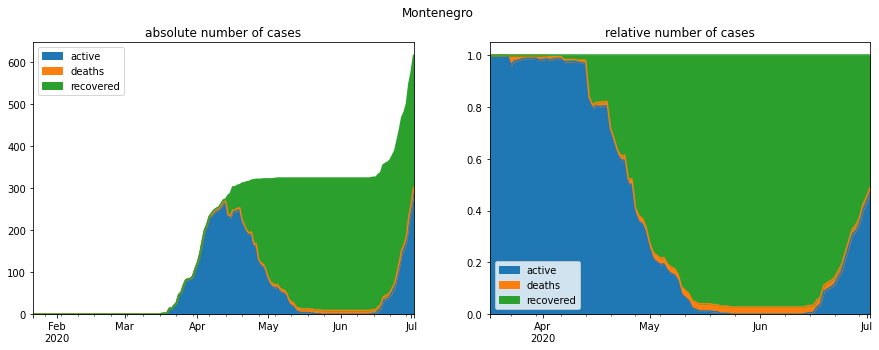

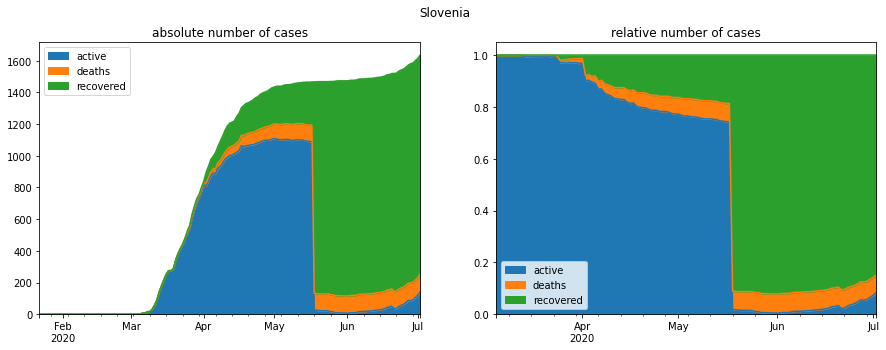

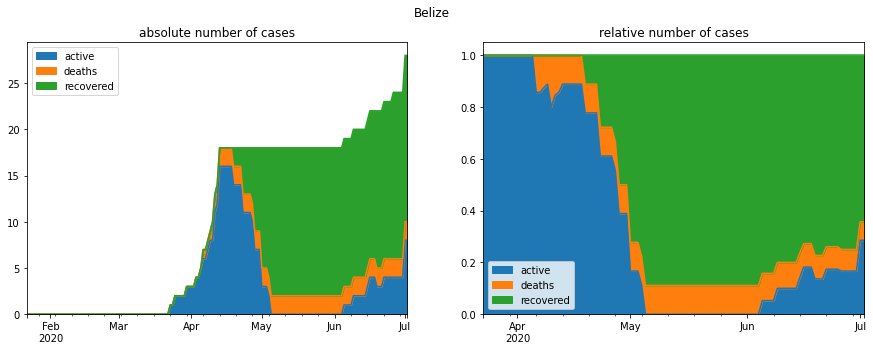

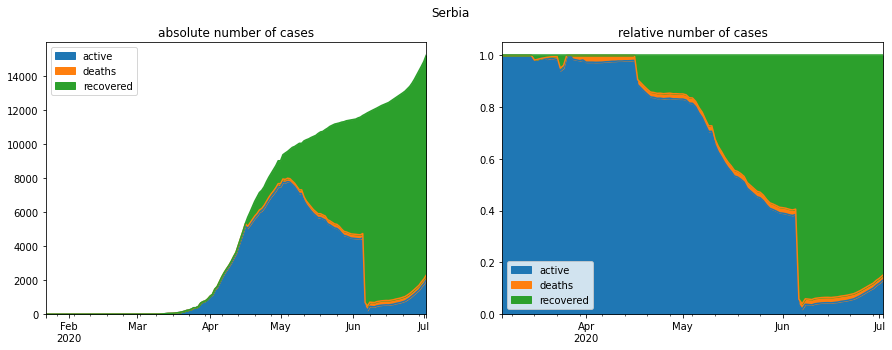

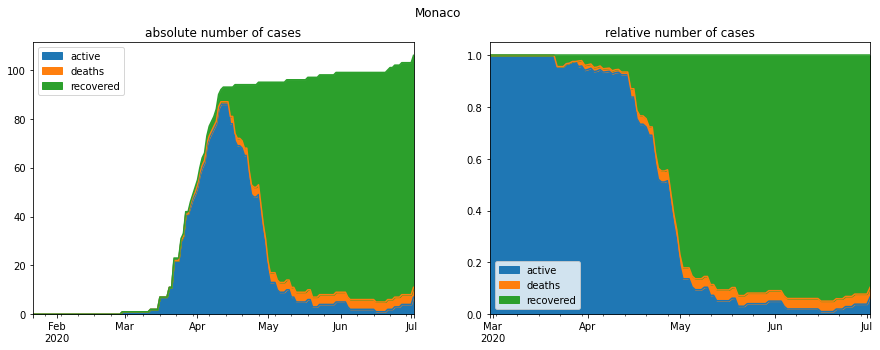

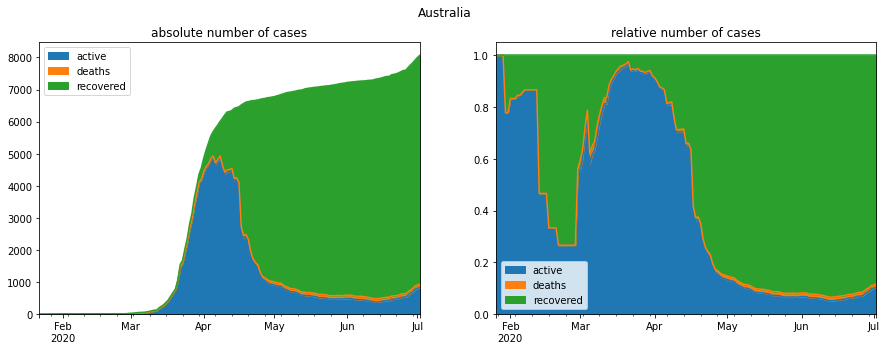

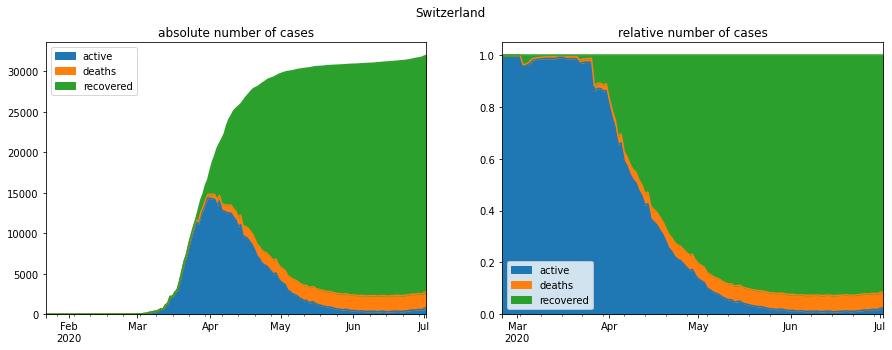

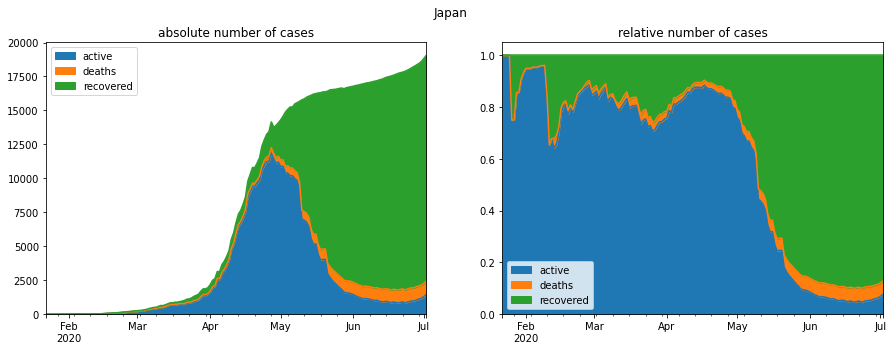

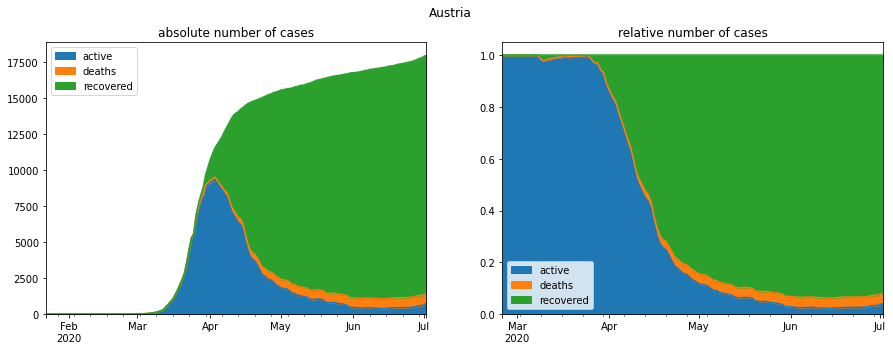

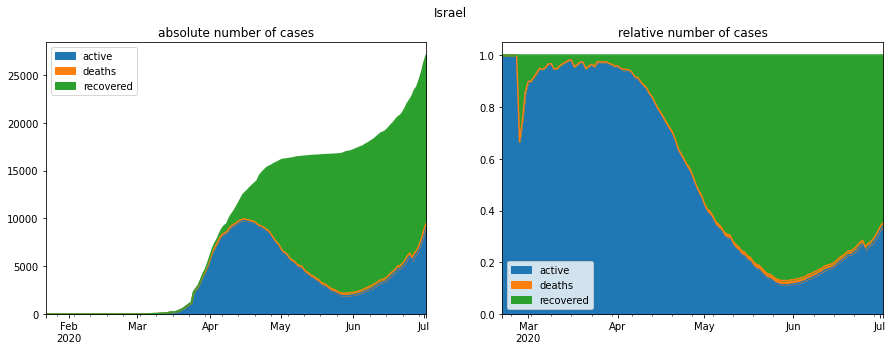

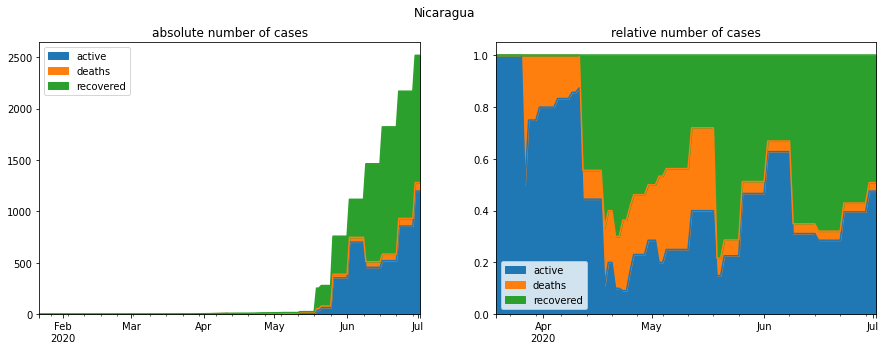

In [209]:

for i,country in enumerate(hotspots):
    _,axs=plt.subplots(1,2,figsize=(15,5))
    d[country].unstack().T.dropna().plot(kind='area',ax=axs[0])
    d_scaled[country].unstack().T.dropna().plot(kind='area',ax=axs[1])
    axs[0].set_title('absolute number of cases')
    axs[1].set_title('relative number of cases')
    plt.suptitle('{}'.format(country))
    plt.show()
